
# HR Database — Python Integration, Analysis & Visualization (PostgreSQL)

In [158]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

try:
    from scipy import stats
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False
    print("scipy not available; hypothesis tests will be skipped.")

DB_USER = "postgres"
DB_PASS = "foxy4289"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "DTSC-691 HR Employee Experience"

CONN_STR = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(CONN_STR, future=True)
print("Connected string composed. Run cells to execute queries.")


Connected string composed. Run cells to execute queries.


In [159]:

def read_sql_df(sql: str, params: dict | None = None) -> pd.DataFrame:
    with engine.connect() as con:
        return pd.read_sql(text(sql), con, params=params)
print("Query helper ready.")


Query helper ready.


## 1) Retrieve data from tables

In [161]:

counts_sql = """
SELECT 'departments' t, COUNT(*) FROM departments
UNION ALL SELECT 'job_roles', COUNT(*) FROM job_roles
UNION ALL SELECT 'employees', COUNT(*) FROM employees
UNION ALL SELECT 'performance_reviews', COUNT(*) FROM performance_reviews
UNION ALL SELECT 'surveys', COUNT(*) FROM surveys
UNION ALL SELECT 'survey_responses', COUNT(*) FROM survey_responses
UNION ALL SELECT 'training_programs', COUNT(*) FROM training_programs
UNION ALL SELECT 'employee_training', COUNT(*) FROM employee_training
UNION ALL SELECT 'benefits', COUNT(*) FROM benefits
UNION ALL SELECT 'employee_benefits', COUNT(*) FROM employee_benefits;
"""
counts_df = read_sql_df(counts_sql)
counts_df


,t,count
0,departments,3
1,job_roles,9
2,employees,1470
3,performance_reviews,4277
4,surveys,1
5,survey_responses,1470
6,training_programs,3
7,employee_training,4115
8,benefits,5
9,employee_benefits,2907


In [162]:

# Basic retrieval previews
employees_df = read_sql_df("""
SELECT e.employee_id, e.first_name, e.last_name, d.department_name, jr.job_title,
       e.years_at_company, e.monthly_income, e.attrition
FROM employees e
LEFT JOIN departments d ON d.department_id = e.department_id
LEFT JOIN job_roles jr ON jr.job_id = e.job_id
LIMIT 10;
""")
employees_df


,employee_id,first_name,last_name,department_name,job_title,years_at_company,monthly_income,attrition
0,20,Aria,Martin,Research & Development,Manufacturing Director,10,9980,No
1,21,John,Lee,Research & Development,Research Scientist,6,3298,No
2,22,Jack,Perez,Research & Development,Laboratory Technician,1,2935,No
3,23,Riley,Thompson,Sales,Manager,25,15427,No
4,24,Levi,White,Research & Development,Research Scientist,3,3944,No
5,26,Lillian,Sanchez,Research & Development,Manufacturing Director,4,4011,No
6,27,Dylan,Clark,Sales,Sales Representative,5,3407,Yes
7,28,Aubrey,Ramirez,Research & Development,Research Director,12,11994,No
8,30,Andrew,Robinson,Research & Development,Research Scientist,0,1232,No
9,31,Liam,Walker,Research & Development,Research Scientist,4,2960,Yes


## 2) Build analytic dataset (latest performance, training count, engagement)

In [164]:

analytic_sql = """
WITH latest_pr AS (
  SELECT pr.employee_id, pr.score, pr.review_date,
         ROW_NUMBER() OVER (PARTITION BY pr.employee_id ORDER BY pr.review_date DESC) AS rn
  FROM performance_reviews pr
),
train_ct AS (
  SELECT et.employee_id, COUNT(*) AS trainings
  FROM employee_training et
  GROUP BY et.employee_id
),
latest_survey AS (
  SELECT sr.employee_id,
         sr.engagement_score,
         sr.satisfaction_score,
         sr.response_date,
         ROW_NUMBER() OVER (PARTITION BY sr.employee_id ORDER BY sr.response_date DESC) AS rn
  FROM survey_responses sr
)
SELECT e.employee_id,
       d.department_name,
       jr.job_title,
       e.years_at_company,
       e.monthly_income,
       e.attrition,
       lp.score              AS latest_perf_score,
       COALESCE(tc.trainings, 0) AS trainings_count,
       ls.engagement_score   AS latest_engagement,
       ls.satisfaction_score AS latest_satisfaction
FROM employees e
LEFT JOIN departments d ON d.department_id = e.department_id
LEFT JOIN job_roles jr   ON jr.job_id       = e.job_id
LEFT JOIN latest_pr lp   ON lp.employee_id  = e.employee_id AND lp.rn = 1
LEFT JOIN train_ct tc    ON tc.employee_id  = e.employee_id
LEFT JOIN latest_survey ls ON ls.employee_id = e.employee_id AND ls.rn = 1;
"""

analytic_df = read_sql_df(analytic_sql)
analytic_df.head()


,employee_id,department_name,job_title,years_at_company,monthly_income,attrition,latest_perf_score,trainings_count,latest_engagement,latest_satisfaction
0,20,Research & Development,Manufacturing Director,10,9980,No,3,1,2,1
1,21,Research & Development,Research Scientist,6,3298,No,3,5,1,2
2,22,Research & Development,Laboratory Technician,1,2935,No,3,2,4,4
3,23,Sales,Manager,25,15427,No,3,3,1,4
4,24,Research & Development,Research Scientist,3,3944,No,3,3,4,4


## 3) Descriptive statistics

In [166]:

desc_cols = ['years_at_company', 'monthly_income', 'latest_perf_score',
             'trainings_count', 'latest_engagement', 'latest_satisfaction']
desc = analytic_df[desc_cols].describe(include='all')
desc


,years_at_company,monthly_income,latest_perf_score,trainings_count,latest_engagement,latest_satisfaction
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,7.008163,6502.931293,3.153741,2.799320,2.721769,2.728571
std,6.126525,4707.956783,0.360824,1.289271,1.093082,1.102846
min,0.000000,1009.000000,3.000000,0.000000,1.000000,1.000000
25%,3.000000,2911.000000,3.000000,2.000000,2.000000,2.000000
50%,5.000000,4919.000000,3.000000,3.000000,3.000000,3.000000
75%,9.000000,8379.000000,3.000000,3.000000,4.000000,4.000000
max,40.000000,19999.000000,4.000000,6.000000,4.000000,4.000000


In [167]:

# Department-level KPIs
dept_kpi_sql = """
SELECT d.department_name,
       AVG(sr.engagement_score) AS avg_engagement,
       AVG(sr.satisfaction_score) AS avg_satisfaction
FROM departments d
JOIN employees e ON e.department_id = d.department_id
JOIN survey_responses sr ON sr.employee_id = e.employee_id
GROUP BY d.department_name
ORDER BY d.department_name;
"""
dept_kpi_df = read_sql_df(dept_kpi_sql)
dept_kpi_df


,department_name,avg_engagement,avg_satisfaction
0,Human Resources,2.682540,2.603175
1,Research & Development,2.744017,2.726327
2,Sales,2.679372,2.751121


## 4) Correlations & simple inference

In [169]:

corr_cols = ['years_at_company', 'monthly_income', 'latest_perf_score',
             'trainings_count', 'latest_engagement', 'latest_satisfaction']
corr_df = analytic_df[corr_cols].corr(numeric_only=True)
corr_df


,years_at_company,monthly_income,latest_perf_score,trainings_count,latest_engagement,latest_satisfaction
years_at_company,1.000000,0.514285,0.003435,0.003569,0.001458,-0.003803
monthly_income,0.514285,1.000000,-0.017120,-0.021736,-0.006259,-0.007157
latest_perf_score,0.003435,-0.017120,1.000000,-0.015579,-0.029548,0.002297
trainings_count,0.003569,-0.021736,-0.015579,1.000000,-0.019359,-0.005779
latest_engagement,0.001458,-0.006259,-0.029548,-0.019359,1.000000,-0.006784
latest_satisfaction,-0.003803,-0.007157,0.002297,-0.005779,-0.006784,1.000000


In [170]:

# T-test: performance for high- vs low-training employees (split by median trainings)
if SCIPY_AVAILABLE:
    median_train = analytic_df['trainings_count'].median()
    hi = analytic_df.loc[analytic_df['trainings_count'] > median_train, 'latest_perf_score'].dropna()
    lo = analytic_df.loc[analytic_df['trainings_count'] <= median_train, 'latest_perf_score'].dropna()
    if len(hi) > 1 and len(lo) > 1:
        t_stat, p_val = stats.ttest_ind(hi, lo, equal_var=False, nan_policy='omit')
        print(f"T-test (perf ~ training high vs low): t={t_stat:.3f}, p={p_val:.4f}, N_hi={len(hi)}, N_lo={len(lo)}")
    else:
        print("Not enough data for t-test groups.")
else:
    print("scipy not installed; skipping t-test.")


T-test (perf ~ training high vs low): t=-0.580, p=0.5619, N_hi=307, N_lo=1163


In [171]:

# Chi-square: Attrition vs Training bucket (0 vs >=1 in last year) using employee_training dates
if SCIPY_AVAILABLE:
    # Build last-365 training flag
    recent_train_sql = """
    SELECT e.employee_id,
           CASE WHEN EXISTS (
             SELECT 1 FROM employee_training et
             WHERE et.employee_id = e.employee_id
               AND et.enrollment_date >= CURRENT_DATE - INTERVAL '365 days'
           ) THEN 1 ELSE 0 END AS recent_training
    FROM employees e;
    """
    rt = read_sql_df(recent_train_sql)
    merged = analytic_df.merge(rt, on='employee_id', how='left')
    merged['attrit_flag'] = (merged['attrition'] == 'Yes').astype(int)

    # contingency table
    ct = pd.crosstab(merged['recent_training'], merged['attrit_flag'])
    if ct.shape == (2,2):
        chi2, p, dof, exp = stats.chi2_contingency(ct.values)
        print("Chi-square Attrition vs Recent Training:")
        print(ct)
        print(f"chi2={chi2:.3f}, p={p:.4f}, dof={dof}")
    else:
        print("Could not build a 2x2 contingency table; check data.")
else:
    print("scipy not installed; skipping chi-square test.")


Chi-square Attrition vs Recent Training:
attrit_flag         0    1
recent_training           
0                  39   15
1                1194  222
chi2=4.772, p=0.0289, dof=1


## 5) Visualizations (Matplotlib)

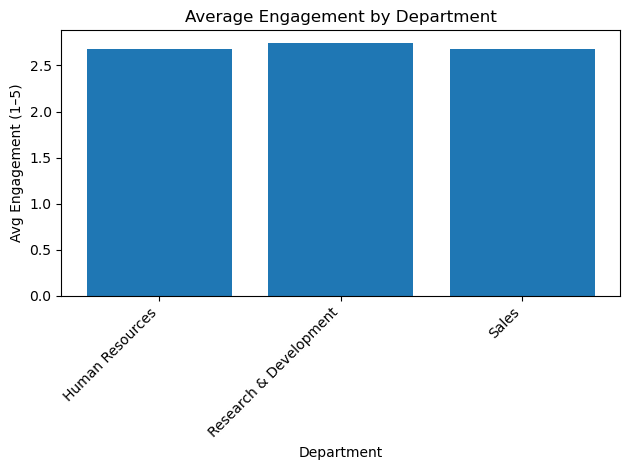

In [173]:

# Bar: Average engagement by department
dept_avg_df = dept_kpi_df.copy()
plt.figure()
plt.bar(dept_avg_df['department_name'], dept_avg_df['avg_engagement'])
plt.title("Average Engagement by Department")
plt.xlabel("Department")
plt.ylabel("Avg Engagement (1–5)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


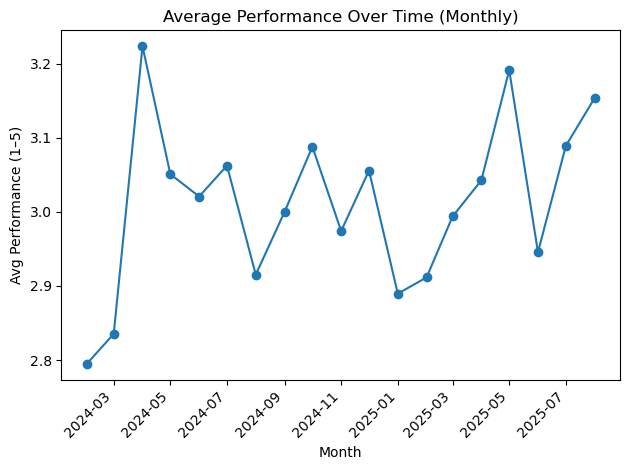

In [174]:

# Line: Monthly average performance
trend_sql = """
SELECT DATE_TRUNC('month', review_date)::date AS month,
       AVG(score) AS avg_score
FROM performance_reviews
GROUP BY 1
ORDER BY 1;
"""
trend_df = read_sql_df(trend_sql)

plt.figure()
plt.plot(trend_df['month'], trend_df['avg_score'], marker='o')
plt.title("Average Performance Over Time (Monthly)")
plt.xlabel("Month")
plt.ylabel("Avg Performance (1–5)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


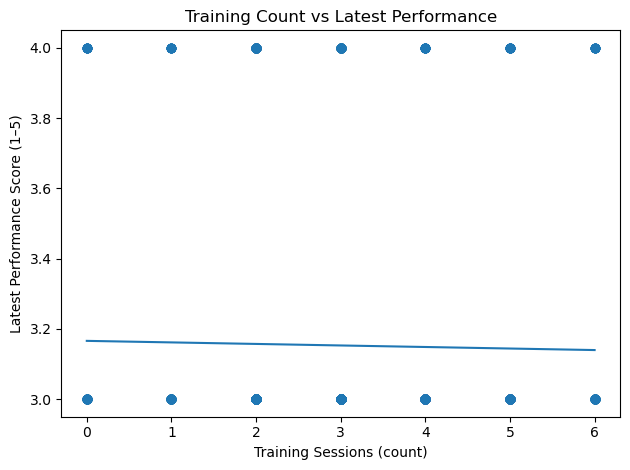

In [175]:

# Scatter: trainings vs latest performance with simple regression line
x = analytic_df['trainings_count'].astype(float)
y = analytic_df['latest_perf_score'].astype(float)
mask = x.notna() & y.notna()
xv, yv = x[mask], y[mask]

plt.figure()
plt.scatter(xv, yv)
# Simple OLS line (numpy polyfit)
if len(xv) > 1:
    m, b = np.polyfit(xv, yv, 1)
    xs = np.linspace(xv.min(), xv.max(), 50)
    ys = m * xs + b
    plt.plot(xs, ys)
plt.title("Training Count vs Latest Performance")
plt.xlabel("Training Sessions (count)")
plt.ylabel("Latest Performance Score (1–5)")
plt.tight_layout()
plt.show()


## 6) Save analysis outputs

In [177]:

analytic_df.to_csv("analytic_dataset.csv", index=False)
dept_kpi_df.to_csv("dept_kpis.csv", index=False)
trend_df.to_csv("performance_trend_monthly.csv", index=False)
corr_df.to_csv("correlations.csv", index=False)
print("Saved CSVs: analytic_dataset.csv, dept_kpis.csv, performance_trend_monthly.csv, correlations.csv")


Saved CSVs: analytic_dataset.csv, dept_kpis.csv, performance_trend_monthly.csv, correlations.csv
